In [0]:
import torch
!pip install pyro-ppl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro
from torch.autograd import Variable
from pyro.infer.autoguide import *
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine

     |████████████████████████████████| 378kB 4.8MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
     time  sunspot.year
0  1700.5           8.3
1  1701.5          18.3
2  1702.5          26.7
3  1703.5          38.3
4  1704.5          60.0


(array([16., 25., 25., 21., 10., 16., 14.,  8., 16., 13.,  9., 16.,  8.,
         7., 10., 14.,  9.,  6.,  7.,  8.,  7.,  6.,  5.,  1.,  5.,  6.,
         2.,  5.,  5.,  3.,  3.,  3.,  4.,  2.,  1.,  0.,  0.,  0.,  2.,
         1.]),
 array([  0.    ,   6.7325,  13.465 ,  20.1975,  26.93  ,  33.6625,
         40.395 ,  47.1275,  53.86  ,  60.5925,  67.325 ,  74.0575,
         80.79  ,  87.5225,  94.255 , 100.9875, 107.72  , 114.4525,
        121.185 , 127.9175, 134.65  , 141.3825, 148.115 , 154.8475,
        161.58  , 168.3125, 175.045 , 181.7775, 188.51  , 195.2425,
        201.975 , 208.7075, 215.44  , 222.1725, 228.905 , 235.6375,
        242.37  , 249.1025, 255.835 , 262.5675, 269.3   ]),
 <a list of 40 Patch objects>)

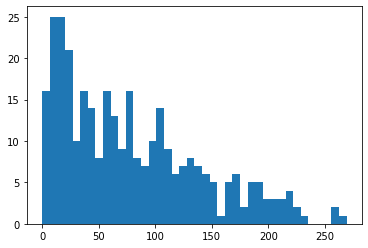

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
print (df.head())

plt.hist(df['sunspot.year'].values, bins=40)

In [0]:
import time

N = df.shape[0]

data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
def crp_model(data):
    alpha0 = pyro.sample('alpha', dist.Gamma(2, 0.5))
    # alpha0 = 2.
    cluster_rates = {}  
    crp_counts = []  # build this incrementally
    for i in range(len(data)):
        # sample from a CRP
        weights = torch.tensor(crp_counts + [alpha0], dtype=torch.float32) 
        weights /= weights.sum()
        crp_weights = pyro.param("weights_{}".format(i), Variable(weights), constraint=constraints.simplex)
        # print (crp_weights)

        zi = pyro.sample("z_{}".format(i), dist.Categorical(crp_weights))
        zi = zi.item() 

        if zi >= len(crp_counts):
            crp_counts.append(1)  # sit at a new table
        else:
            crp_counts[zi] += 1  # sit at an existing table

        if zi not in cluster_rates.keys():
            cluster_rates[zi] = pyro.sample("lambda_{}".format(zi), dist.Uniform(0, 200))
        lambda_i = cluster_rates[zi]
        pyro.sample("obs_{}".format(i), dist.Poisson(lambda_i), obs=data[i])

# guide = AutoDiagonalNormal(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))]))
# guide = AutoDelta(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))]))
# guide = AutoIAFNormal(poutine.block(crp_model, expose=['weights_318'] + ['lambda_{}'.format(i) for i in range(30)]))
# guide = AutoIAFNormal(poutine.block(crp_model, expose=['weights_318', 'lambda_0', 'lambda_1', 'lambda_2'])) # hidden dim?
# guide = AutoContinuous(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))] + ['weights_{}'.format(i) for i in range(len(data) - 1)]))
# guide = AutoIAFNormal(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))]))

def guide(data):
    a_q = pyro.param('a', torch.tensor(2.0), constraint=constraints.positive)
    b_q = pyro.param('b', torch.tensor(0.5), constraint=constraints.positive)
    ub_Unif = pyro.param('ub', torch.tensor(200), constraint=constraints.positive) 
    lb_Unif = pyro.param('lb', torch.tensor(0), constraint=constraints.positive)
    alpha_q = pyro.sample('alpha', dist.Gamma(a_q, b_q))
    cluster_rates_q = {}  # sample this lazily
    crp_counts_q = []  # build this incrementally
    for i in range(len(data)):
        # sample from a CRP
        weights_q = torch.tensor(crp_counts_q + [alpha_q], dtype=torch.float32) 
        weights_q /= weights_q.sum()
        # crp_weights_q = pyro.param("weights_{}".format(i), Variable(weights_q), constraint=constraints.simplex)

        print (weights_q)
        zi_q = pyro.sample("z_{}".format(i), dist.Categorical(weights_q))
        zi_q = zi_q.item() 

        if zi_q >= len(crp_counts_q):
            crp_counts_q.append(1)  # sit at a new table
        else:
            crp_counts_q[zi_q] += 1  # sit at an existing table

        if zi_q not in cluster_rates_q.keys():
            cluster_rates_q[zi_q] = pyro.sample("lambda_{}".format(zi_q), dist.Uniform(lb_Unif, ub_Unif))

optim = Adam({"lr": 0.05})
svi = SVI(crp_model, guide, optim, loss=TraceEnum_ELBO(), num_samples=1000)

def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        loss = svi.step(data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train(500)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))


tensor([1.])
tensor([0.2297, 0.7703])
tensor([0.3737, 0.6263])
tensor([0.3148, 0.1574, 0.5277])
tensor([0.4080, 0.1360, 0.4560])
tensor([0.4789, 0.1197, 0.4014])
tensor([0.5346, 0.1069, 0.3585])
tensor([0.4830, 0.0966, 0.0966, 0.3238])
tensor([0.5285, 0.0881, 0.0881, 0.2953])
tensor([0.4857, 0.0810, 0.1619, 0.2714])
tensor([0.5242, 0.0749, 0.1498, 0.2511])
tensor([0.4877, 0.0697, 0.1393, 0.0697, 0.2336])
tensor([0.4560, 0.0651, 0.1954, 0.0651, 0.2184])
tensor([0.4892, 0.0612, 0.1835, 0.0612, 0.2050])
tensor([0.5187, 0.0576, 0.1729, 0.0576, 0.1932])
tensor([0.4904, 0.1090, 0.1635, 0.0545, 0.1827])
tensor([0.4651, 0.1033, 0.1550, 0.0517, 0.0517, 0.1732])
tensor([0.4422, 0.1474, 0.1474, 0.0491, 0.0491, 0.1647])
tensor([0.4215, 0.1405, 0.1405, 0.0468, 0.0468, 0.0468, 0.1570])
tensor([0.4026, 0.1790, 0.1342, 0.0447, 0.0447, 0.0447, 0.1500])
tensor([0.3854, 0.2141, 0.1285, 0.0428, 0.0428, 0.0428, 0.1436])
tensor([0.4106, 0.2053, 0.1232, 0.0411, 0.0411, 0.0411, 0.1377])
tensor([0.3944, 0.1972

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-81-82319b84e5da>", line 74, in <module>
    train(500)
  File "<ipython-input-81-82319b84e5da>", line 70, in train
    loss = svi.step(data)
  File "/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py", line 103, in step
    loss = self.loss_and_grads(self.model, self.guide, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pyro/infer/traceenum_elbo.py", line 374, in loss_and_grads
    for model_trace, guide_trace in self._get_traces(model, guide, *args, **kwargs):
  File "/usr/local/lib/python3.6/dist-packages/pyro/infer/traceenum_elbo.py", line 317, in _get_traces
    yield self._get_trace(model, guide, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pyro/infer/traceenum_elbo.py", line 271, in _get_trace
    "flat", self.max_plate_nesti

RuntimeError: ignored

In [0]:
post = guide.get_posterior()

# print (pyro.param('weights_318'))

# print (post.__dict__)

print (post.transforms[0]._inverse(post.sample()))
# print (post.sample())

tensor([9.0224e-01, 1.9303e-02, 3.8258e-03, 4.3883e-03, 8.7918e-05, 2.3445e-04,
        1.2411e-03, 2.2590e-03, 8.7918e-05, 6.2304e-02, 1.1887e-03, 4.3959e-05,
        1.4653e-04, 1.4653e-05, 1.4653e-05, 1.4653e-05, 1.4653e-05, 1.4653e-05,
        2.5773e-03], grad_fn=<DivBackward0>)
tensor([ 1.0144e+00, -3.5299e-01, -1.1869e+00, -1.1496e+00,  6.8926e-02,
        -1.6430e+00,  8.0017e-02, -4.3675e-01, -3.6981e-01, -1.2241e+00,
        -2.7404e-01, -2.1751e-01,  1.3451e+00,  8.1884e-01, -1.1512e+00,
        -1.6906e+00, -9.4966e-05, -5.3308e-01,  1.6007e+00],
       grad_fn=<StackBackward>)


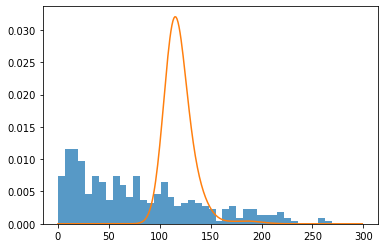

In [0]:
# print(pyro.get_param_store())

from scipy.stats import poisson

X = np.arange(0, 300)

# print (pyro.param('weights_318').detach().numpy())
# print ([pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(10)])

def mop(X):
  weights = pyro.param('weights_318').detach().numpy()
  # rates = [pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(len(weights) - 1)]
  rates = [i.detach().item() for i in list(cluster_rates.values())]
  return sum( [weights[i] * poisson.pmf(X, rates[i]) for i in range(len(weights))] )


Y = mop(X)
# print(Y)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(X, Y)
plt.show()
